The derivative of a Gaussian Process is still a Gaussian Process and what we need to compute mean and variance is just the derivative of the kernel function. In this notebook we are going to consider the kernel to be the RBF kernel, since it is easy to differentiate. We are going to make the analyical derivatives of the kernel. This is for educational purposes. 
You can give a look at chapter 9 of 
``` Williams, C.K. and Rasmussen, C.E., 2006. Gaussian processes for machine learning (Vol. 2, No. 3, p. 4). Cambridge, MA: MIT press. ``` The book will help you understand how I am computing the mean and variance by simply using the derivative of the kernel function when making prediction on a new input. 
**This is an advanced topic**. If you feel lost or feel that there is a mistake, please contact the author (Giovanni Franzese) at g.franzese@tudelft.nl.

Here is a small recap of what we are going to compute: 
We first fit the posterior distribution p(f|y) using Bayes theorem $p(f|y)=p(y|f)p(f)$ where we have the hypothesis that the likelihood is Gaussian and also the prior is a Gaussian Process. 

We can make predictions on new points, where we can predict $p(f^*|f,y)$, or we can also predict $p(y^*|f,y)$ by simply using the estimated likelihood noise. 
When we compute the derivatives, we only care about the probability distribution of the latent function, i.e., $ p(f' ^*| f,y) $and $p(f''^*| f,y)$. The fact that there was a noisy input will still affect the prediction of mean and variance, given that the prediction $p(f|y)$ takes the noise into account in the diagonal of the covariance matrix. 

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sympy import symbols, diff, exp, simplify

# Define symbols
x, x_prime, Sigma_v, sigma_l = symbols('x x_prime Sigma_v sigma_l')

# Define the function k_RBF(x, x_prime)
k_RBF = Sigma_v * exp(-(x - x_prime)**2/(2* (sigma_l)**2))


dk_dx_prime = simplify(diff(k_RBF, x_prime, 1))

# print("dk_dx_prime :", dk_dx_prime)

ratio_dk_dx_prime = simplify(dk_dx_prime/ k_RBF)

print("coefficient of dk_dx_prime that multiplies the kernel itself ", ratio_dk_dx_prime)

dk2_dx_dx_prime = diff(diff(k_RBF, x, 1), x_prime, 1)


dk2_dx_dx_prime= simplify(dk2_dx_dx_prime.subs(x, x_prime))


print("dk2_dx_dx_prime :",dk2_dx_dx_prime)

dk2_dx_prime = simplify(diff(k_RBF, x_prime, 2))

# print("dk2_dx_prime :", dk2_dx_prime)

print("coefficient of dk2_dx_prime that multiplies the kernel itself ", simplify(dk2_dx_prime/ k_RBF))

dk4_dx2_dx_prime2 = diff(diff(k_RBF, x, 2), x_prime, 2)


dk4_dx2_dx_prime2=simplify(dk4_dx2_dx_prime2.subs(x, x_prime))

print("dk4_dx2_dx_prime2 :", dk4_dx2_dx_prime2)

coefficient of dk_dx_prime that multiplies the kernel itself  (x - x_prime)/sigma_l**2
dk2_dx_dx_prime : Sigma_v/sigma_l**2
coefficient of dk2_dx_prime that multiplies the kernel itself  (-sigma_l**2 + (x - x_prime)**2)/sigma_l**4
dk4_dx2_dx_prime2 : 3*Sigma_v/sigma_l**4


In [3]:
class GPR():
    def __init__(self, kernel, alpha=1e-10, n_restarts_optimizer=1):
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20)

    def fit(self, X, Y):
        self.X=X
        self.Y=Y
        self.n_features=np.shape(self.X)[1]
        self.n_samples=np.shape(self.X)[0]
        gp_ = self.gp.fit(self.X, self.Y)

        self.kernel_ = gp_.kernel_

        self.length_scales=self.kernel_.get_params()['k1__k2__length_scale']
        
        self.noise_var_ = gp_.alpha + self.kernel_.get_params()['k2__noise_level']

        self.Sigma_v   = self.kernel_.get_params()['k1__k1__constant_value']
        
        self.kernel_params_= [self.kernel_.get_params()['k1__k2__length_scale'], self.kernel_.get_params()['k1']]

        K_ = self.kernel_(self.X, self.X) + (self.noise_var_ * np.eye(len(self.X)))
        
        self.K_inv = np.linalg.inv(K_)

    def predict(self, x, return_std=True): # here we predict p(y*|f,y) 
        k_star = self.kernel_(self.X, x)
        k_star_K_inv_ = np.transpose(k_star) @ self.K_inv
        self.mu=k_star_K_inv_ @ self.Y
        self.sigma=None
        if return_std==True:
            self.sigma = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            
        self.std= np.sqrt(self.sigma)    
        return self.mu, self.std 
    
    def predict_first_derivative(self, x): # here we predict p(f'*| f, y). 
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. mean of the derivative function 
        2. predicted standar deviation of the first derivative
        Each output has shape n_query x n_features x n_outputs.
        The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
        For the derivative of sigma n_outputs is equal to 1"""
        lscale=self.kernel_params_[0].reshape(-1,1)
        lscale_stack= np.hstack([lscale]*self.n_samples)
        alfa=  np.matmul(self.K_inv, self.Y)
        df_dx=[]
        sigma_df_dx=[]
        for i in range(np.shape(x)[0]):
            k_star= self.kernel_(self.X, x[i,:].reshape(1,-1))
            k_star_T=k_star.transpose()
            k_star_stack= np.vstack([k_star_T]*self.n_features)
            #coefficient of dk_dx_prime that multiplies the kernel itself  (x - x_prime)/sigma_l**2
            dk_star_dx= k_star_stack * (self.X- x[i,:]).transpose()/ ( lscale_stack** 2)
            df_dx.append(dk_star_dx @ alfa)     
            dk_star_dx_K_inv_= dk_star_dx @  self.K_inv
            #dk2_dx_dx_prime : Sigma_v/sigma_l**2
            var_der=self.Sigma_v/(lscale**2) - dk_star_dx_K_inv_ @ dk_star_dx.transpose()
            sigma_df_dx.append(np.sqrt(var_der))
        return np.array(df_dx), np.array(sigma_df_dx)
     
    def predict_second_derivative(self, x): # here we predict p(f''*| f, y).
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. mean of the second derivative function 
        2. predicted standar deviation of the second derivative
        Each output has shape n_query x n_features x n_outputs.
        The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
        For the derivative of sigma n_outputs is equal to 1"""
        lscale=self.kernel_params_[0].reshape(-1,1)
        lscale_stack= np.hstack([lscale]*self.n_samples)
        alfa=  np.matmul(self.K_inv, self.Y)
        df2_dx2=[]
        sigma_df2_dx2=[]
        for i in range(np.shape(x)[0]):
            k_star= self.kernel_(self.X, x[i,:].reshape(1,-1))
            k_star_T=k_star.transpose()
            k_star_stack= np.vstack([k_star_T]*self.n_features)
            -Sigma_v*(2*sigma_l**2 - (x - x_prime)**2)/(4*sigma_l**4)
            #coefficient of dk2_dx_prime that multiplies the kernel itself  (-sigma_l**2 + (x - x_prime)**2)/sigma_l**4
            dk2_star_dx2= k_star_stack*(-(lscale_stack** 2) + (self.X- x[i,:]).transpose()**2)/(lscale_stack**4)
            df2_dx2.append(dk2_star_dx2 @ alfa)     
            dk2_star_dx2_K_inv_= dk2_star_dx2 @  self.K_inv 
            #dk4_dx2_dx_prime2 : 3*Sigma_v/sigma_l**4
            var_der2=3* self.Sigma_v/(lscale**4) - dk2_star_dx2_K_inv_ @ dk2_star_dx2.transpose()
            sigma_df2_dx2.append(np.sqrt(var_der2))
        return np.array(df2_dx2), np.array(sigma_df2_dx2)

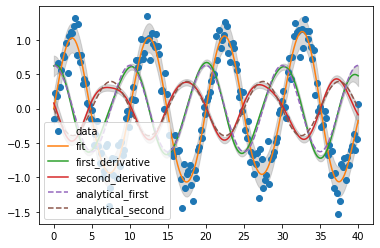

In [4]:
amplitude=1
frequency=0.1
noise=0.2
number_of_cycles=4
omega= 2*np.pi*frequency
number_samples=200
time=np.linspace(0, number_of_cycles/frequency,number_samples)
y=amplitude * np.sin(omega*time) + np.random.normal(0,noise,number_samples)
dx_analytical= amplitude * omega* np.cos(omega*time)
dx2_analytical= - amplitude * omega**2 * np.sin(omega*time)
# prepare inputs for gp
X=time.reshape(-1,1)
Y=y.reshape(-1,1)
plt.plot(X,Y, 'o')
k = C(constant_value=1)  * RBF(1*np.ones(1)) + WhiteKernel(0.01 )
gp=GPR(kernel=k)
gp.fit(X,Y)
t_test=np.linspace(0, number_of_cycles/frequency, number_samples).reshape(-1,1)
y_pred, std =gp.predict(t_test)

f_prime, std_prime=gp.predict_first_derivative(t_test)
f_second, std_second=gp.predict_second_derivative(t_test)
plt.plot(t_test, y_pred)
plt.plot(t_test, f_prime[:,0,0])
plt.plot(t_test, f_second[:,0,0])
plt.plot(t_test, dx_analytical, '--')
plt.plot(t_test, dx2_analytical, '--')
plt.fill_between(t_test.reshape(-1,), y_pred.reshape(-1,)-np.diag(std), y_pred.reshape(-1,)+np.diag(std), color='gray', alpha=0.3)
plt.fill_between(t_test.reshape(-1,), f_prime[:,0,0]-std_prime.reshape(-1,), f_prime[:,0,0]+std_prime.reshape(-1,), color='gray', alpha=0.3)
plt.fill_between(t_test.reshape(-1,), f_second[:,0,0]-std_second.reshape(-1,), f_second[:,0,0]+std_second.reshape(-1,), color='gray', alpha=0.3)

plt.legend(["data","fit","first_derivative", "second_derivative", "analytical_first", "analytical_second" ])